In [9]:
import pandas as pd
import preprocess
import regression
import numpy as np
import sklearn
from sklearn.preprocessing import KBinsDiscretizer

In [10]:
test_data = pd.read_csv('./data/test set.csv')
train_data = pd.read_csv('./data/trainSet.csv')

In [11]:
# list(test_data), len(test_data)

In [12]:
# list(train_data), len(train_data)

In [13]:
train_x = train_data.values[:, :-1]
train_target = train_data.values[:, -1].reshape(-1, 1)
sample, features = train_x.shape

In [14]:
z_scale_processed_x, mean, std = preprocess.z_score_scaling(train_x)
min_max_scaled_x = preprocess.min_max_scaling(train_x)
processed_test, _, _ = preprocess.z_score_scaling(test_data.values, mean, std)


In [15]:
quad_x = z_scale_processed_x
quad_test = processed_test
for i in range(2, 5):
    quad_x = np.hstack((quad_x, np.power(z_scale_processed_x, i)))
    quad_test = np.hstack((quad_test, np.power(processed_test, i)))
quad_processed, quad_mean, quad_std = preprocess.z_score_scaling(quad_x)
quad_test_processed, _, _ = preprocess.z_score_scaling(quad_test, quad_mean, quad_std)

In [16]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
scaler = sklearn.preprocessing.StandardScaler()
poly_x = poly.fit_transform(train_x)
scaler.fit(poly_x)
processed_poly = scaler.transform(poly_x)
processed_poly_test = scaler.transform(poly.transform(test_data.values))

In [26]:
pp = poly.fit_transform(z_scale_processed_x)

In [24]:
import sklearn.model_selection
import sklearn.metrics
# trainer is used for training and should return the trained parameters,
# tester should receive x and the parameters and return the predicted item
# args and kwargs are extra parameters to pass to the trainer.
def k_fold(k, trainer, tester, x, target, *args, **kwargs):
    samples, features = x.shape
    from sklearn.model_selection import StratifiedKFold
    skf = sklearn.model_selection.StratifiedKFold(n_splits=k, shuffle=True)
    skf.get_n_splits(x)
    precisions_sum = 0
    f1_sum = 0
    i = 0
    for train_index, test_index in skf.split(x, target):
        training_set = x[train_index]
        training_targets = target[train_index]
        test_set = x[test_index]
        test_targets = target[test_index]
        the = trainer(training_set, training_targets, *args, **kwargs)
        predicted = tester(test_set, the)
        predicted = np.array([1 if e > 0.5 else 0 for e in predicted]).reshape(test_targets.shape)
        corrects = (test_targets == predicted).sum()
        print('At k=%d' % (i))
        print('Precision: %f, Recall: %f' % (sklearn.metrics.precision_score(test_targets, predicted),
                                             sklearn.metrics.recall_score(test_targets, predicted)))
        print('correct rate: %f, f1 score: %f' % (corrects / len(predicted), 
                                                    sklearn.metrics.f1_score(test_targets, predicted)))
        i += 1
        precisions_sum += corrects / len(predicted)
        f1_sum += sklearn.metrics.f1_score(test_targets, predicted)
    result = precisions_sum / k
    print('Average: %f' % result)
    f1_result = f1_sum / k
    print('Average f1 score: %f' % f1_result)
    return result

In [ ]:
iters = 200
lr = 0.2
k_fold(3, regression.regression, regression.logistic_h, processed_poly, train_target, 
       regression.logistic_h, iters, lr, lbd=5.0, log=True, logInterval=50)

19.40977274891777
1.1772240032929304
1.531893729444827
1.542161350046843


In [22]:
def shuffle(x, label):
    shuffled = np.hstack((x, label))
    np.random.shuffle(shuffled)
    shuffled_x = shuffled[:, :-1]
    shuffled_target = shuffled[:, -1].reshape(-1, 1)
    return shuffled_x, shuffled_target

In [23]:
iters = 500
lr = 0.2
shuffled_x, shuffled_label = shuffle(z_scale_processed_x, train_target)
the = regression.regression(z_scale_processed_x, train_target, regression.logistic_h, iters, lr, lbd=5.0, log=True)

2.479528125968463
0.6677671836011526
0.660634653431319
0.6597069461473278
0.6595142755955541


In [24]:
result = regression.logistic_h(z_scale_processed_x, the)

In [25]:
result = [1 if e > 0.5 else 0 for e in result]

In [27]:
accurate = 0
for i in range(len(result)):
    if result[i] == train_target[i]:
        accurate += 1
accurate

121644

In [32]:
result = regression.logistic_h(processed_test, the)
result = [1 if e > 0.5 else 0 for e in result]
print(np.sum(result))

139725


In [ ]:
pd.DataFrame([[i+1, 1 if result[i] > 0.5 else 0] for i in range(len(result))]).to_csv('result.csv', header=['Id', 'Predicted'], index=False)

In [18]:
import torch
from torch.nn import functional as F

In [19]:
class Net(torch.nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = []
        for i in range(len(layers) - 1):
            self.layers.append(torch.nn.Linear(layers[i], layers[i + 1]))
            self.add_module('layer%d'%(i+1), self.layers[-1])
        
    def forward(self, x):
        o = x
        for i in range(len(self.layers)-1):
            o = self.layers[i](o)
            o = F.dropout(o, p=0.1)
            o = F.relu(o)
        return torch.sigmoid(self.layers[-1](o))
    

In [31]:
x_in = processed_poly
x_test = processed_poly_test
hidden_count = int((x_in.shape[0]) / (2 * (x_in.shape[1] + 2)))
layers = [x_in.shape[1], hidden_count, 2]
Net(layers)

Net(
  (layer1): Linear(in_features=561, out_features=177, bias=True)
  (layer2): Linear(in_features=177, out_features=2, bias=True)
)

In [44]:
epoch = 500
def trainer(x, target):
    net = Net(layers)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_func = torch.nn.CrossEntropyLoss()
    for i in range(epoch):
        o = net(torch.Tensor(x))
        loss = loss_func(o, torch.Tensor(target).long().squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(loss.item())
    return net

def tester(x, n):
    o = n(torch.Tensor(x))
    return torch.max(o, 1)[1].numpy().reshape(-1, 1)

In [45]:
k_fold(5, trainer, tester, x_in, train_target)

0.6940355896949768
0.6428335309028625
0.6360560059547424
0.6302533745765686
0.6266998052597046
At k=0
Precision: 0.619724, Recall: 0.666166
correct rate: 0.617010, f1 score: 0.642106
0.6934293508529663


KeyboardInterrupt: 

In [36]:
clf = trainer(x_in, train_target)
print((tester(x_in, clf) == train_target).sum())

0.6930204629898071
0.6541705131530762
0.6483917832374573
0.6457539796829224
0.6435170769691467
0.6416389346122742
0.6401886343955994
0.6389321684837341
126762


In [40]:
print(tester(x_test, clf).sum())

174738


In [41]:
res = tester(x_test, clf)
pd.DataFrame([[i+1, int(res[i])] for i in range(len(res))]).to_csv('nn.csv', header=['Id', 'Predicted'], index=False)

In [108]:
te = train_x[:, 2]
kb = KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='kmeans')
kb.fit(te.reshape(-1, 1))

KBinsDiscretizer(encode='onehot-dense', n_bins=10, strategy='kmeans')

In [109]:
samples, features = train_x.shape
discretized = np.empty(shape=(samples, 0))
discretizer = []
for i in range(features):
    kb = KBinsDiscretizer(n_bins=20, encode='onehot-dense', strategy='uniform')
    col = train_x[:, i].reshape(-1, 1)
    kb.fit(col)
    discretizer.append(kb)
#     print(i)
    discretized = np.hstack((discretized, kb.transform(col)))

In [110]:
discretized.shape

(200000, 640)

In [18]:
iters = 200
lr = 0.5
k_fold(5, regression.regression, regression.logistic_h, discretized, train_target, 
       regression.logistic_h, iters, lr, lbd=5.0, log=True, logInterval=50)

5.164201496857981
0.8493710190342197
0.750037518652131
0.7174333294845987
0.586625 at k=0
7.036856801796076
0.8543927005530155
0.7598158076018899
0.7249947703874418
0.580575 at k=1
6.7882568962446195
0.8268020560109115
0.7555480123263164
0.7236738801810155
0.586275 at k=2
7.013016941453348
0.8625226108011852
0.7483188563307671
0.7133159906789235
0.592300 at k=3
6.537905596745202
0.8403178038529427
0.7469365415608864
0.7125058931226065
0.582900 at k=4
Average: 0.585735


0.5857349999999999

In [46]:
import sklearn
import sklearn.ensemble
import sklearn.svm
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.tree
import sklearn.model_selection

In [54]:
mmScaler = sklearn.preprocessing.MinMaxScaler()
mmScaler.fit(train_x)
minmax_x = mmScaler.transform(train_x)
minmax_test = mmScaler.transform(test_data.values)

In [47]:
def sk_train(x, y):
    classifier = sklearn.ensemble.AdaBoostClassifier()
    classifier.fit(x, y.ravel())
    return classifier

def sk_test(x, classifier):
    return classifier.predict(x).reshape(-1, 1)

In [48]:
k_fold(5, sk_train, sk_test, processed_poly, train_target)

At k=0
Precision: 0.628204, Recall: 0.648667
correct rate: 0.620809, f1 score: 0.638271
At k=1
Precision: 0.619297, Recall: 0.664598
correct rate: 0.616325, f1 score: 0.641149
At k=2
Precision: 0.625151, Recall: 0.651607
correct rate: 0.618825, f1 score: 0.638105
At k=3
Precision: 0.621581, Recall: 0.655388
correct rate: 0.616500, f1 score: 0.638037
At k=4
Precision: 0.621887, Recall: 0.676572
correct rate: 0.621041, f1 score: 0.648078
Average: 0.618700
Average f1 score: 0.640728


0.6187000011552313

### Gradient boosting

In [36]:
parameters = {
    'n_estimators': [10, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
grid_searcher = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestClassifier(),
                                                     parameters, cv=3, verbose=5, 
                                                     scoring='accuracy', n_jobs=10)

In [38]:
grid_searcher.fit(z_scale_processed_x, train_target.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  25 out of  36 | elapsed:  5.5min remaining:  2.4min
[Parallel(n_jobs=10)]: Done  33 out of  36 | elapsed:  9.2min remaining:   50.4s
[Parallel(n_jobs=10)]: Done  36 out of  36 | elapsed: 10.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'n_estimators': [10, 100, 200], 'max_features': ['sqrt', 'log2'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [34]:
parameters = {
    'criterion': ['friedman_mse'],
    'learning_rate': [0.01], 
    'loss': ['exponential'], 
    'max_depth': [3], 
    'max_features': ['log2'], 
    'min_samples_leaf': [2], 
    'min_samples_split': [2], 
    'n_estimators': [100, 200], 
    'subsample': [0.5, 1]
}
grid_searcher = sklearn.model_selection.GridSearchCV(sklearn.ensemble.GradientBoostingClassifier(),
                                                     parameters, cv=5, verbose=50, 
                                                     scoring='accuracy', n_jobs=10)

grid_searcher.fit(z_scale_processed_x, train_target.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   38.0s
[Parallel(n_jobs=10)]: Done   2 out of  20 | elapsed:   38.4s remaining:  5.8min
[Parallel(n_jobs=10)]: Done   3 out of  20 | elapsed:   38.5s remaining:  3.6min
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:   38.7s remaining:  2.6min
[Parallel(n_jobs=10)]: Done   5 out of  20 | elapsed:   38.7s remaining:  1.9min
[Parallel(n_jobs=10)]: Done   6 out of  20 | elapsed:   54.0s remaining:  2.1min
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:   54.2s remaining:  1.7min
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:   54.5s remaining:  1.4min
[Parallel(n_jobs=10)]: Done   9 out of  20 | elapsed:   54.5s remaining:  1.1min
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:   54.7s remaining:   54.7s
[Parallel(n_jobs=10)]: Done  11 out of  20 | elapsed:  1.9min remaining:

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'criterion': ['friedman_mse'], 'learning_rate': [0.01], 'loss': ['exponential'], 'max_depth': [3], 'max_features': ['log2'], 'min_samples_leaf': [2], 'min_samples_split': [2], 'n_estimators': [100, 200], 'subsample': [0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=50)

In [39]:
print(grid_searcher.best_params_)
print(grid_searcher.best_score_)

{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 10}
0.452855


In [43]:
params = grid_searcher.best_params_
def sk_train(x, y):
    classifier = sklearn.ensemble.RandomForestClassifier(**params, n_jobs=10)
    classifier.fit(x, y.ravel())
    return classifier

def sk_test(x, classifier):
    return classifier.predict(x).reshape(-1, 1)

In [44]:
k_fold(5, sk_train, sk_test, z_scale_processed_x, train_target)

At k=0
Precision: 0.626312, Recall: 0.538148
correct rate: 0.596210, f1 score: 0.578892
At k=1
Precision: 0.621856, Recall: 0.528528
correct rate: 0.591100, f1 score: 0.571406
At k=2
Precision: 0.626496, Recall: 0.535508
correct rate: 0.595800, f1 score: 0.577440
At k=3
Precision: 0.624310, Recall: 0.531582
correct rate: 0.593450, f1 score: 0.574226
At k=4
Precision: 0.621736, Recall: 0.532163
correct rate: 0.591740, f1 score: 0.573473
Average: 0.593660
Average f1 score: 0.575088


0.5936599776484938

In [23]:
clf = sk_train(z_scale_processed_x, train_target)
print(sk_test(processed_test, clf).sum())

183267.0


In [47]:
classifier = sk_train(z_scale_processed_x, train_target)

In [48]:
res = classifier.predict(z_scale_processed_x)
accurate = 0
for i in range(len(res)):
    if res[i] == train_target[i]:
        accurate += 1
accurate / len(res)

1.0

In [49]:
res = classifier.predict(processed_test)
res.sum()

119731.0

In [32]:
pd.DataFrame([[i+1, int(res[i])] for i in range(len(res))]).to_csv('forest.csv', header=['Id', 'Predicted'], index=False)

In [67]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(z_scale_processed_x)

5

In [68]:
for train_index, test_index in skf.split(z_scale_processed_x, train_target):
    print(len(train_index), len(test_index))

159999 40001
160000 40000
160000 40000
160000 40000
160001 39999


In [63]:
import xgboost as xgb
train_xgx = xgb.DMatrix(z_scale_processed_x, label=train_target)
train_xgx

In [70]:
def xgTrain(x, y):
    xgx = xgb.DMatrix(x, label=y)
    param = {'max_depth': 10, 'eta': 1, 'objective': 'binary:logistic', 'nthread': 2}
    num_round = 10
    bst = xgb.train(param, xgx, num_round)
    return bst

def xgTest(x, bst):
    xgx = xgb.DMatrix(x)
    return bst.predict(xgx)

In [96]:
k_fold(5, xgTrain, xgTest, z_scale_processed_x, train_target)

correct rate: 0.613760, f1 score: 0.635665 at k=0
correct rate: 0.610075, f1 score: 0.628032 at k=1
correct rate: 0.608925, f1 score: 0.630809 at k=2
correct rate: 0.613750, f1 score: 0.637749 at k=3
correct rate: 0.612215, f1 score: 0.633023 at k=4
Average: 0.611745


0.611744992278247

In [72]:
xgClassifier = xgTrain(minmax_x, train_target)

In [73]:
res = xgTest(minmax_x, xgClassifier)
res = [1 if e > 0.5 else 0 for e in res]
accurate = 0
for i in range(len(res)):
    if res[i] == train_target[i]:
        accurate += 1
accurate / len(res)

0.980355

In [74]:
res = xgTest(minmax_test, xgClassifier)
res = [1 if e > 0.5 else 0 for e in res]
np.sum(res)

136660

In [75]:
pd.DataFrame([[i+1, int(res[i])] for i in range(len(res))]).to_csv('xg.csv', header=['Id', 'Predicted'], index=False)

In [79]:
xgClassifier = xgTrain(z_scale_processed_x, train_target)
res = xgTest(z_scale_processed_x, xgClassifier)
res = [1 if e > 0.5 else 0 for e in res]
accurate = 0
for i in range(len(res)):
    if res[i] == train_target[i]:
        accurate += 1
print(accurate / len(res))
res = xgTest(processed_test, xgClassifier)
res = [1 if e > 0.5 else 0 for e in res]
np.sum(res)

0.966925


126570

In [12]:
import matplotlib.pyplot as plt

In [49]:
def makeBar(x, y):
    kb = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
    positiveCounts = [0 for i in range(10)]
    negativeCounts = [0 for i in range(10)]
    kb.fit(x.reshape(-1, 1))
    transformed = kb.transform(x.reshape(-1, 1))
    for i in range(len(transformed)):
        if y[i] == 1:
            positiveCounts[int(transformed[i])] += 1
        else:
            negativeCounts[int(transformed[i])] += 1
    interval = (np.max(x) - np.min(x)) / 10
    width = interval / 2
    ind = [np.min(x) + i * interval for i in range(10)]
    p1 = plt.plot(ind, negativeCounts, width)
    p2 = plt.plot(ind, positiveCounts, width)
    plt.legend((p1[0], p2[0]), ('negative', 'positive'))
    plt.show()

0:


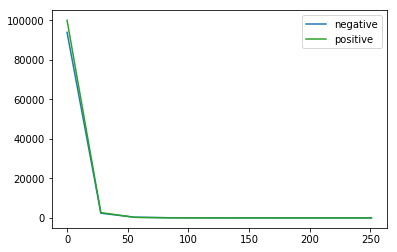

1:


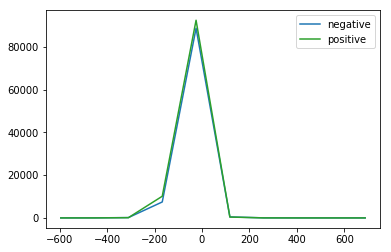

2:


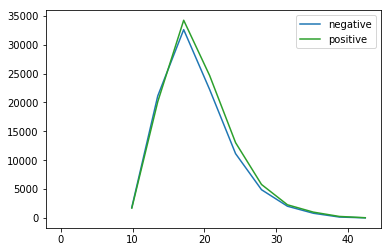

3:


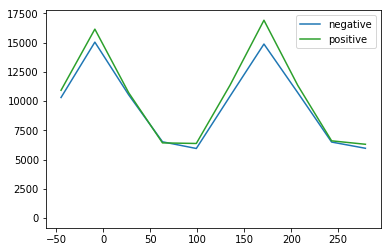

4:


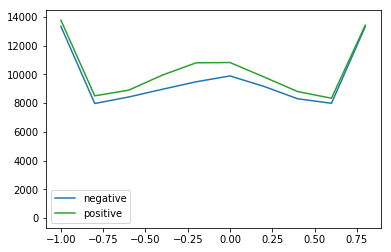

5:


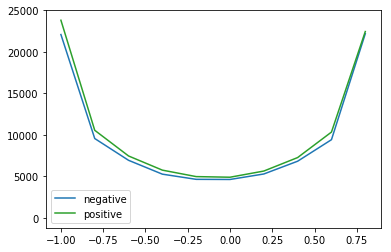

6:


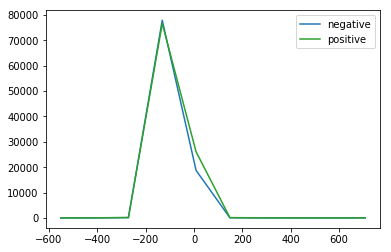

7:


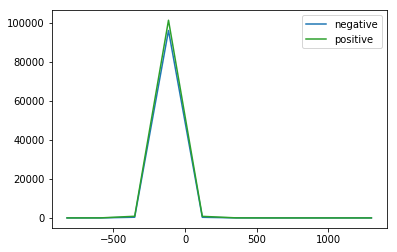

8:


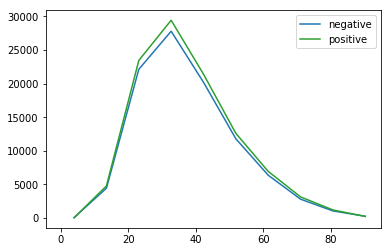

9:


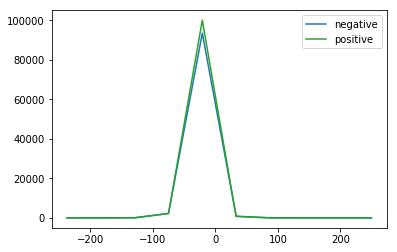

10:


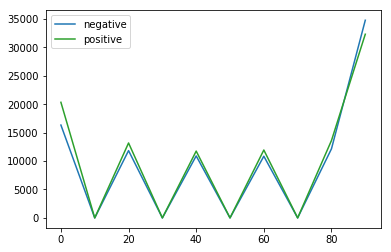

11:


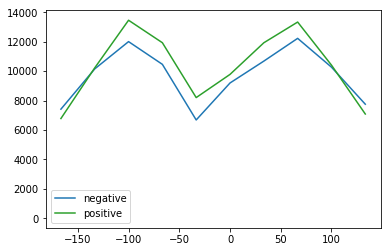

12:


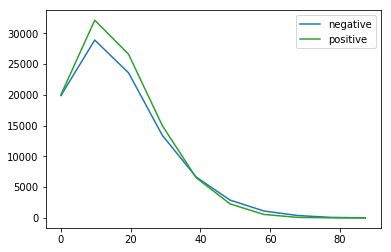

13:


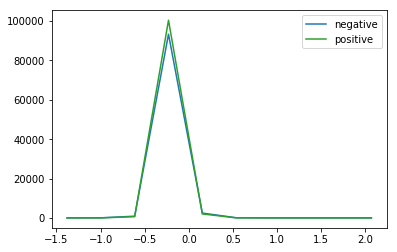

14:


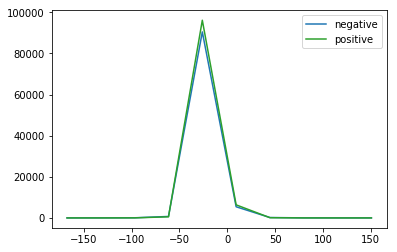

15:


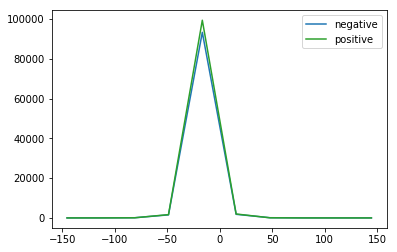

16:


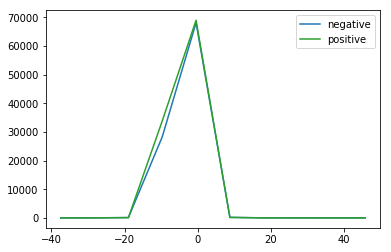

17:


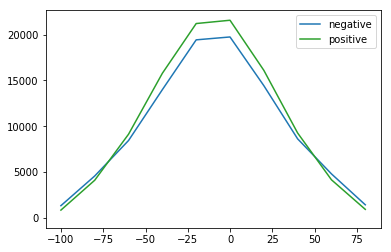

18:


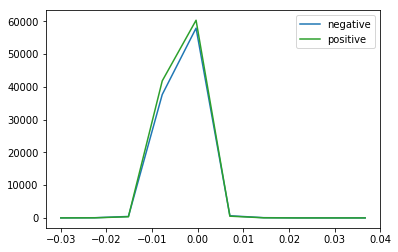

19:


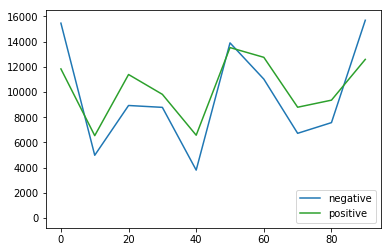

20:


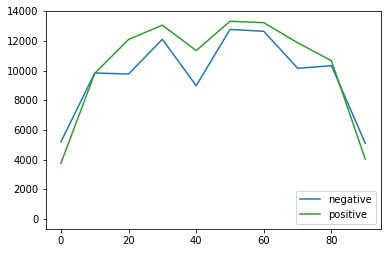

21:


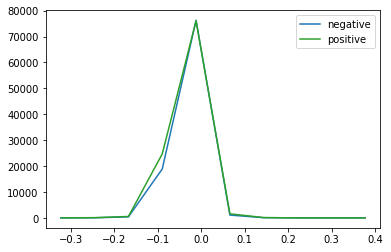

22:


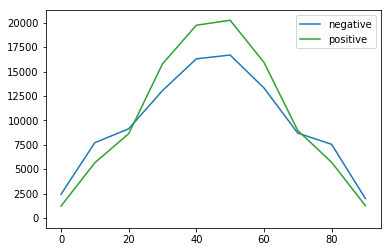

23:


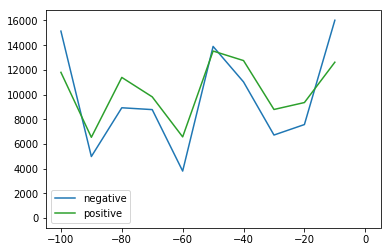

24:


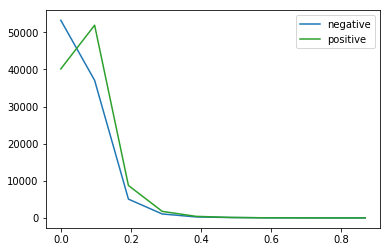

25:


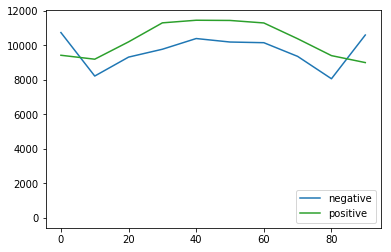

26:


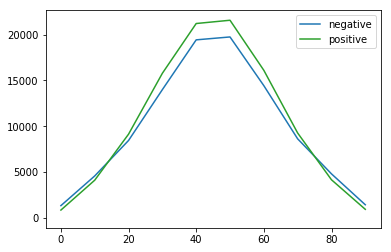

27:


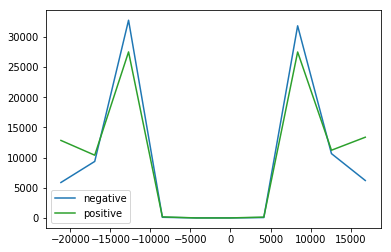

28:


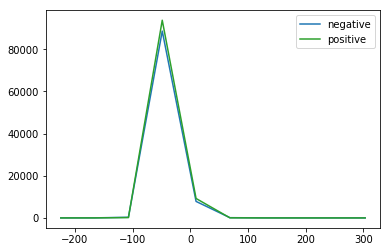

29:


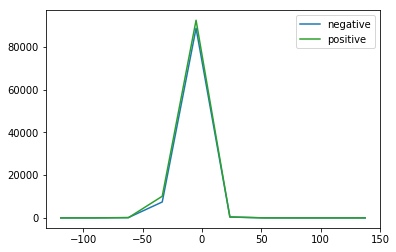

30:


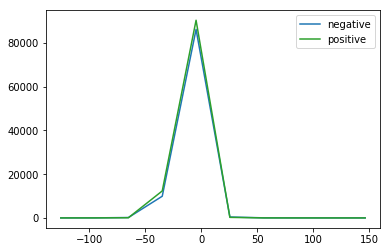

31:


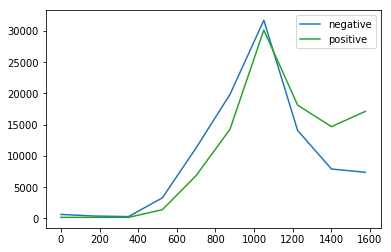

In [50]:
for i in range(features):
    print('%d:'%i)
    makeBar(train_x[:, i], train_target)

0:


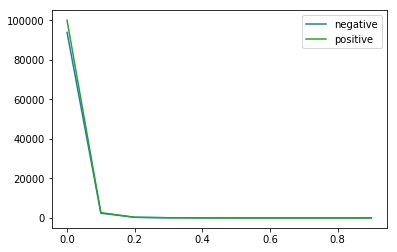

1:


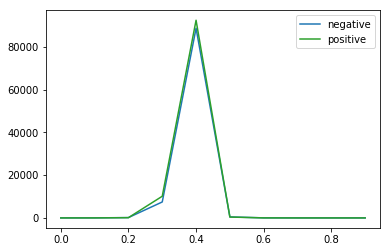

2:


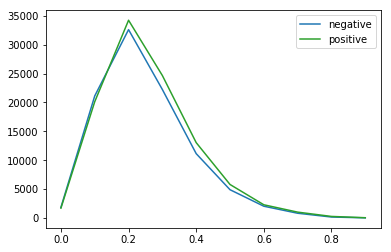

3:


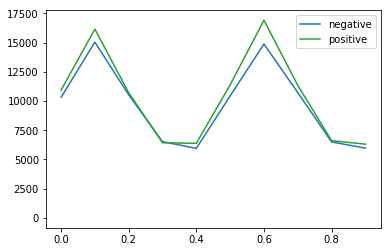

4:


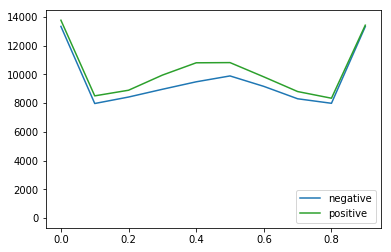

5:


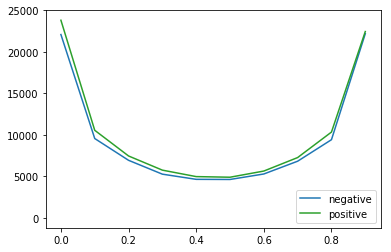

6:


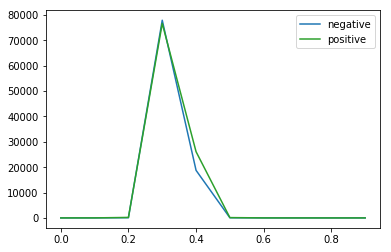

7:


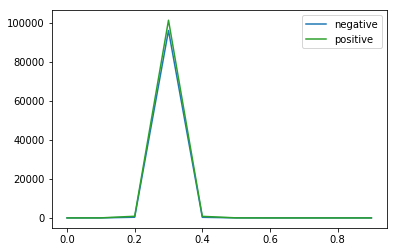

8:


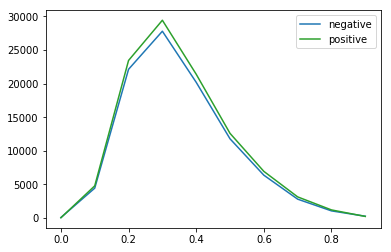

9:


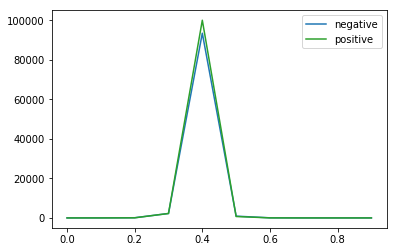

10:


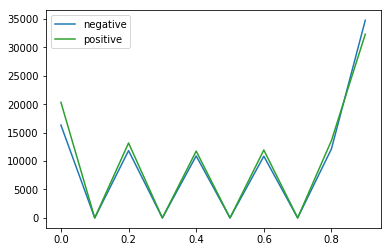

11:


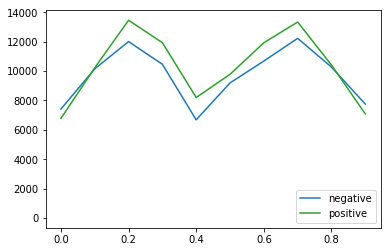

12:


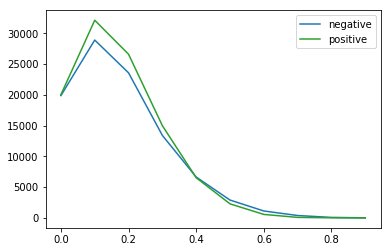

13:


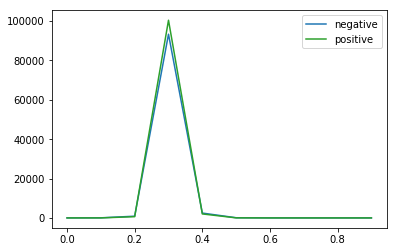

14:


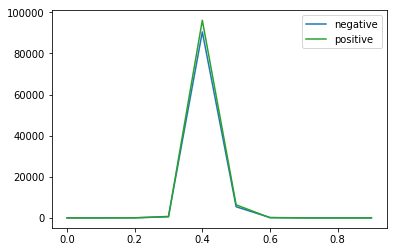

15:


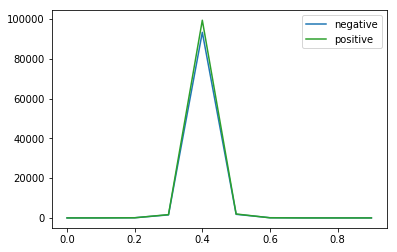

16:


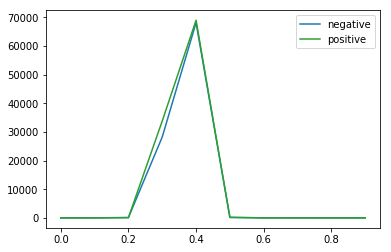

17:


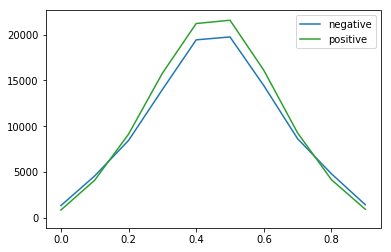

18:


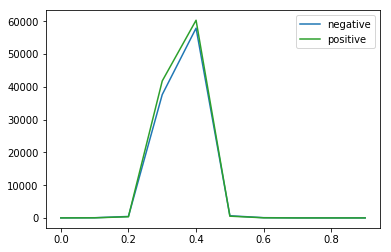

19:


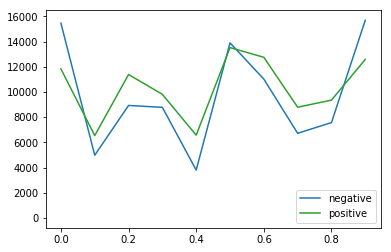

20:


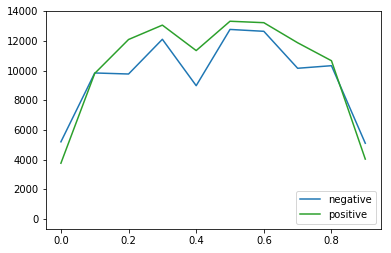

21:


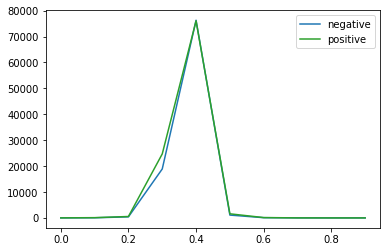

22:


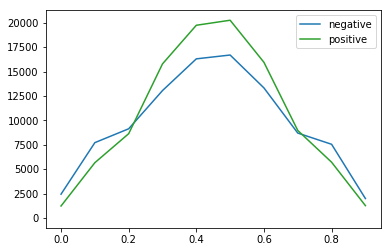

23:


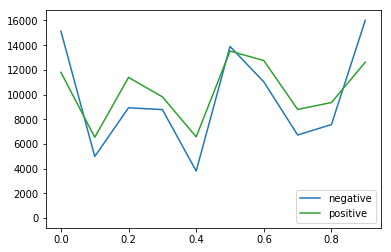

24:


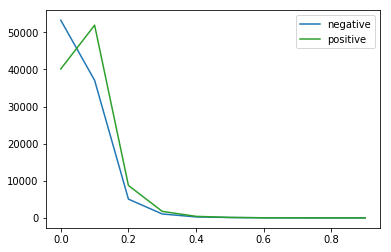

25:


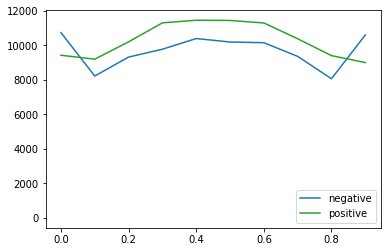

26:


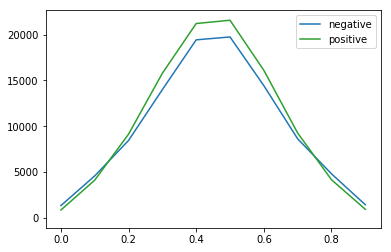

27:


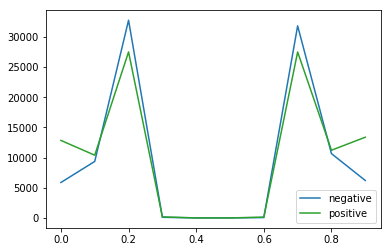

28:


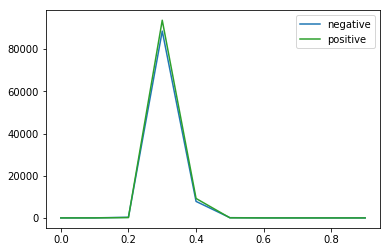

29:


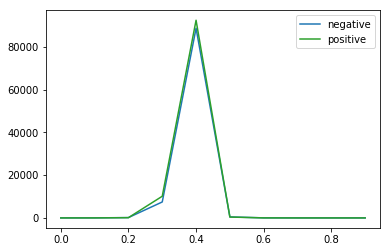

30:


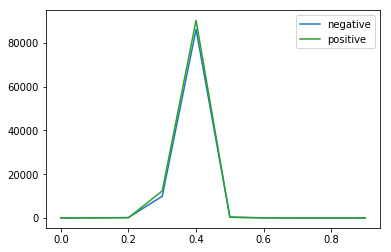

31:


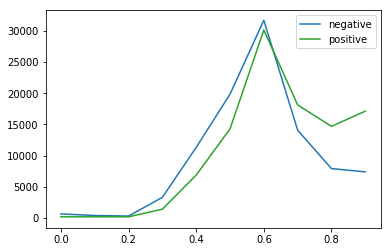

In [58]:
for i in range(features):
    print('%d:'%i)
    makeBar(minmax_x[:, i], train_target)